In [1]:
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_path = "/content/drive/MyDrive/Colab Notebooks/archive1"

In [4]:
print("Files/folders inside dataset:")
print(os.listdir(data_path)[:20])  # show first 20 entries


Files/folders inside dataset:
['train', 'val', 'test']


In [5]:
import os, random, numpy as np, torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [6]:
data_path = "/content/drive/MyDrive/Colab Notebooks/archive1"
train_dir = f"{data_path}/train"
test_dir  = f"{data_path}/test"


In [7]:
from sklearn.model_selection import StratifiedShuffleSplit
from pathlib import PurePath
import shutil, os

train_dir = f"{data_path}/train"
val_dir   = f"{data_path}/val"
IMG_EXT = {".jpg",".jpeg",".png",".bmp",".tif",".tiff"}

if not os.path.exists(val_dir):
    os.makedirs(val_dir, exist_ok=True)
    classes = [c for c in sorted(os.listdir(train_dir))
               if os.path.isdir(os.path.join(train_dir, c))]

    X, y = [], []
    for c in classes:
        paths = [os.path.join(train_dir, c, f)
                 for f in os.listdir(os.path.join(train_dir, c))
                 if os.path.splitext(f)[1].lower() in IMG_EXT]
        # need at least 2 samples per class for a split
        if len(paths) < 2:
            print(f"Skipping class '{c}' (only {len(paths)} image).")
            continue
        X += paths
        y += [c]*len(paths)

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    idx_train, idx_val = next(sss.split(X, y))
    X_val = [X[i] for i in idx_val]

    for src in X_val:
        cls = PurePath(src).parent.name
        dst_dir = os.path.join(val_dir, cls)
        os.makedirs(dst_dir, exist_ok=True)
        shutil.move(src, os.path.join(dst_dir, os.path.basename(src)))

    print("Validation split created at:", val_dir)
else:
    print("ℹval/ already exists; skipping split.")


ℹval/ already exists; skipping split.


In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
from pathlib import Path, PurePath
import shutil, os

val_dir = f"{data_path}/val"
if not os.path.exists(val_dir):
    os.makedirs(val_dir, exist_ok=True)
    classes = sorted(os.listdir(train_dir))
    X, y = [], []
    for c in classes:
        imgs = [str(PurePath(train_dir, c, f)) for f in os.listdir(os.path.join(train_dir,c))]
        X += imgs; y += [c]*len(imgs)

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    idx_train, idx_val = next(sss.split(X, y))
    X_val = [X[i] for i in idx_val]
    # move val files into val/<class>/
    for p in X_val:
        cls = PurePath(p).parent.name
        os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
        shutil.move(p, os.path.join(val_dir, cls, PurePath(p).name))


In [9]:
import timm, torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

IMG_SIZE = 224
BATCH    = 32

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.1,0.1,0.1,0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])

train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds   = datasets.ImageFolder(f"{data_path}/val", transform=val_tfms)
test_ds  = datasets.ImageFolder(test_dir, transform=val_tfms)

train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

CLASSES = train_ds.classes; NUM_CLASSES = len(CLASSES); CLASSES


['altar',
 'apse',
 'bell_tower',
 'column',
 'dome(inner)',
 'dome(outer)',
 'flying_buttress',
 'gargoyle',
 'stained_glass',
 'vault']

In [10]:
#pip install --upgrade timm


In [11]:
def build_model(model_name="resnet50", pretrained=True, num_classes=NUM_CLASSES):
    model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)
    return model.to(device)

# options:
#   "resnet50"
#   "vit_base_patch16_224"
#   "tf_efficientnetv2_s"
model_name = "resnet50"  # change to vit_base_patch16_224 or tf_efficientnetv2_s for other runs

#pretrained model
model = build_model(model_name)

#training from scratch
#model = build_model(model_name, pretrained=False)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
!pip install torchmetrics==1.3.2 -q


In [13]:
import os, time
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm



EPOCHS = 10
LR     = 2e-4
WD     = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
scaler    = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

# ---- set up logging ----
timestamp = time.strftime("%Y%m%d-%H%M%S")
log_dir   = Path("/content/drive/MyDrive")
log_dir.mkdir(parents=True, exist_ok=True)
log_path  = log_dir / f"{model_name}_training_log_{timestamp}.txt"

with open(log_path, "w") as f:
    f.write("# Training log\n")
    f.write(f"# model_name\t{model_name}\n")
    f.write(f"# epochs\t{EPOCHS}\n")
    f.write(f"# lr\t{LR}\n")
    f.write(f"# weight_decay\t{WD}\n")
    f.write("# epoch\ttrain_loss\ttrain_acc\tval_loss\tval_acc\tcheckpoint\n")

best_val_acc, patience, bad = 0.0, 8, 0

for epoch in range(1, EPOCHS+1):
    # -------------------
    # Train
    # -------------------
    model.train()
    train_loss_sum, train_correct, train_count = 0.0, 0, 0
    for x, y in tqdm(train_dl, desc=f"Epoch {epoch} [train]"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device=="cuda")):
            logits = model(x)
            loss   = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        batch_size = x.size(0)
        train_loss_sum += loss.item() * batch_size
        train_correct  += (logits.argmax(1) == y).sum().item()
        train_count    += batch_size

    train_loss = train_loss_sum / max(1, train_count)
    train_acc  = train_correct  / max(1, train_count)

    # -------------------
    # Validation
    # -------------------
    model.eval()
    val_loss_sum, val_correct, val_count = 0.0, 0, 0
    with torch.no_grad(), torch.cuda.amp.autocast(enabled=(device=="cuda")):
        for x, y in tqdm(val_dl, desc=f"Epoch {epoch} [val]", leave=False):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss   = criterion(logits, y)

            batch_size = x.size(0)
            val_loss_sum += loss.item() * batch_size
            val_correct  += (logits.argmax(1) == y).sum().item()
            val_count    += batch_size

    val_loss = val_loss_sum / max(1, val_count)
    val_acc  = val_correct  / max(1, val_count)

    print(f"Epoch {epoch:02d} | train_loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"val_loss {val_loss:.4f} acc {val_acc:.4f}")

    checkpoint_path = ""  # default (no save)
    if val_acc > best_val_acc:
        best_val_acc, bad = float(val_acc), 0
        # NEW: checkpoint file includes epoch + accuracy
        checkpoint_path = log_dir / f"{model_name}_best_epoch{epoch:02d}_acc{val_acc:.4f}.pth"
        torch.save(model.state_dict(), checkpoint_path)
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping.")
            break

    # log per epoch with checkpoint info (if saved)
    with open(log_path, "a") as f:
        f.write(f"{epoch}\t{train_loss:.6f}\t{train_acc:.6f}\t{val_loss:.6f}\t{val_acc:.6f}\t{checkpoint_path}\n")

# ---- wrap up
with open(log_path, "a") as f:
    f.write("# training_finished\t1\n")
    f.write(f"# best_val_acc\t{best_val_acc:.6f}\n")

print(f"Metrics log saved to: {log_path}")
print(f"Best model path: {checkpoint_path if checkpoint_path else 'No improvement saved'}")


/tmp/ipython-input-3973503877.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))
Epoch 1 [train]:   0%|          | 0/254 [00:00<?, ?it/s]/tmp/ipython-input-3973503877.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Epoch 1 [train]: 100%|██████████| 254/254 [22:21<00:00,  5.28s/it]
/tmp/ipython-input-3973503877.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 01 | train_loss 1.0693 acc 0.6903 | val_loss 0.2579 acc 0.9256


Epoch 2 [train]: 100%|██████████| 254/254 [00:40<00:00,  6.31it/s]


Epoch 02 | train_loss 0.2367 acc 0.9291 | val_loss 0.1612 acc 0.9512


Epoch 3 [train]: 100%|██████████| 254/254 [00:40<00:00,  6.21it/s]


Epoch 03 | train_loss 0.1505 acc 0.9534 | val_loss 0.1399 acc 0.9562


Epoch 4 [train]: 100%|██████████| 254/254 [00:40<00:00,  6.28it/s]


Epoch 04 | train_loss 0.1027 acc 0.9677 | val_loss 0.1368 acc 0.9591


Epoch 5 [train]: 100%|██████████| 254/254 [00:40<00:00,  6.33it/s]


Epoch 05 | train_loss 0.0747 acc 0.9786 | val_loss 0.1385 acc 0.9611


Epoch 6 [train]: 100%|██████████| 254/254 [00:40<00:00,  6.25it/s]


Epoch 06 | train_loss 0.0641 acc 0.9798 | val_loss 0.1505 acc 0.9552


Epoch 7 [train]: 100%|██████████| 254/254 [00:39<00:00,  6.41it/s]


Epoch 07 | train_loss 0.0535 acc 0.9835 | val_loss 0.1361 acc 0.9576


Epoch 8 [train]: 100%|██████████| 254/254 [00:40<00:00,  6.29it/s]


Epoch 08 | train_loss 0.0404 acc 0.9878 | val_loss 0.1245 acc 0.9645


Epoch 9 [train]: 100%|██████████| 254/254 [00:40<00:00,  6.29it/s]


Epoch 09 | train_loss 0.0320 acc 0.9913 | val_loss 0.1401 acc 0.9611


Epoch 10 [train]: 100%|██████████| 254/254 [00:39<00:00,  6.41it/s]
                                                               

Epoch 10 | train_loss 0.0350 acc 0.9890 | val_loss 0.1397 acc 0.9606
Metrics log saved to: /content/drive/MyDrive/resnet50_training_log_20250924-083957.txt
Best model path: No improvement saved


In [14]:
# ===== Test evaluation (append to same log) =====
import torch
from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassF1Score,
    MulticlassConfusionMatrix
)

# If you tracked the best path during training, ensure it's here:
# best_ckpt_path is set whenever a new best is found; if not defined, fall back to last checkpoint_path
try:
    best_ckpt_path
except NameError:
    best_ckpt_path = str(log_dir / f"{model_name}_best.pth")  # fallback

# Load best checkpoint for testing
if best_ckpt_path and Path(best_ckpt_path).exists():
    model.load_state_dict(torch.load(best_ckpt_path, map_location=device))
else:
    print(f"[WARN] Best checkpoint not found at: {best_ckpt_path}. Using current model weights.")

model.eval()

all_preds  = []
all_targets = []
with torch.no_grad(), torch.cuda.amp.autocast(enabled=(device=="cuda")):
    for x, y in tqdm(test_dl, desc="Testing"):
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        preds  = logits.argmax(dim=1)
        all_preds.append(preds.detach().cpu())
        all_targets.append(y.detach().cpu())

y_pred = torch.cat(all_preds, dim=0)
y_true = torch.cat(all_targets, dim=0)

# --- Metrics ---
acc_metric   = MulticlassAccuracy(num_classes=NUM_CLASSES)
prec_micro   = MulticlassPrecision(num_classes=NUM_CLASSES, average='micro')
rec_micro    = MulticlassRecall(num_classes=NUM_CLASSES, average='micro')
f1_micro     = MulticlassF1Score(num_classes=NUM_CLASSES, average='micro')

prec_macro   = MulticlassPrecision(num_classes=NUM_CLASSES, average='macro')
rec_macro    = MulticlassRecall(num_classes=NUM_CLASSES, average='macro')
f1_macro     = MulticlassF1Score(num_classes=NUM_CLASSES, average='macro')

prec_weight  = MulticlassPrecision(num_classes=NUM_CLASSES, average='weighted')
rec_weight   = MulticlassRecall(num_classes=NUM_CLASSES, average='weighted')
f1_weight    = MulticlassF1Score(num_classes=NUM_CLASSES, average='weighted')

# Per-class (arrays of length NUM_CLASSES)
prec_percls  = MulticlassPrecision(num_classes=NUM_CLASSES, average=None)
rec_percls   = MulticlassRecall(num_classes=NUM_CLASSES, average=None)
f1_percls    = MulticlassF1Score(num_classes=NUM_CLASSES, average=None)

# Confusion matrix
cm_metric    = MulticlassConfusionMatrix(num_classes=NUM_CLASSES)

test_acc      = acc_metric(y_pred, y_true).item()
test_prec_mi  = prec_micro(y_pred, y_true).item()
test_rec_mi   = rec_micro(y_pred, y_true).item()
test_f1_mi    = f1_micro(y_pred, y_true).item()

test_prec_ma  = prec_macro(y_pred, y_true).item()
test_rec_ma   = rec_macro(y_pred, y_true).item()
test_f1_ma    = f1_macro(y_pred, y_true).item()

test_prec_w   = prec_weight(y_pred, y_true).item()
test_rec_w    = rec_weight(y_pred, y_true).item()
test_f1_w     = f1_weight(y_pred, y_true).item()

percls_prec   = prec_percls(y_pred, y_true).tolist()
percls_rec    = rec_percls(y_pred, y_true).tolist()
percls_f1     = f1_percls(y_pred, y_true).tolist()

cm            = cm_metric(y_pred, y_true).to(torch.int64).tolist()

# Resolve class labels (optional)
try:
    class_labels = list(map(str, class_names))  # must be iterable of length NUM_CLASSES
    if len(class_labels) != NUM_CLASSES:
        raise ValueError
except Exception:
    class_labels = [f"class_{i}" for i in range(NUM_CLASSES)]

# --- Append to the same log file ---
with open(log_path, "a") as f:
    f.write("# test_results\n")
    f.write(f"# best_ckpt_used\t{best_ckpt_path}\n")
    f.write(f"test_accuracy\t{test_acc:.6f}\n")

    f.write("test_precision_micro\t{:.6f}\n".format(test_prec_mi))
    f.write("test_recall_micro\t{:.6f}\n".format(test_rec_mi))
    f.write("test_f1_micro\t{:.6f}\n".format(test_f1_mi))

    f.write("test_precision_macro\t{:.6f}\n".format(test_prec_ma))
    f.write("test_recall_macro\t{:.6f}\n".format(test_rec_ma))
    f.write("test_f1_macro\t{:.6f}\n".format(test_f1_ma))

    f.write("test_precision_weighted\t{:.6f}\n".format(test_prec_w))
    f.write("test_recall_weighted\t{:.6f}\n".format(test_rec_w))
    f.write("test_f1_weighted\t{:.6f}\n".format(test_f1_w))

    f.write("# per_class_metrics\t(label\tprecision\trecall\tf1)\n")
    for idx, (lbl, p, r, s) in enumerate(zip(class_labels, percls_prec, percls_rec, percls_f1)):
        f.write(f"{idx}\t{lbl}\t{p:.6f}\t{r:.6f}\t{s:.6f}\n")

    f.write("# confusion_matrix_rows_are_true_cols_are_pred\n")
    for row in cm:
        f.write("\t".join(map(str, row)) + "\n")

print(f"Test metrics appended to: {log_path}")


/tmp/ipython-input-3118877321.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=(device=="cuda")):


[WARN] Best checkpoint not found at: /content/drive/MyDrive/resnet50_best.pth. Using current model weights.


Testing: 100%|██████████| 45/45 [09:50<00:00, 13.13s/it]

Test metrics appended to: /content/drive/MyDrive/resnet50_training_log_20250924-083957.txt


In [15]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=2ad13ee520a4a02f543bb3e6a851191b3e82a7cb0072591acb405a08e6764d5d
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


Using test image: /content/drive/MyDrive/Colab Notebooks/archive1/test/363.jpg


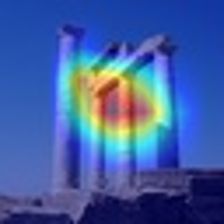


Predicted Class Probabilities (sorted):
column         : 99.99%
gargoyle       : 0.00%
apse           : 0.00%
bell_tower     : 0.00%
vault          : 0.00%
flying_buttress: 0.00%
dome(outer)    : 0.00%
altar          : 0.00%
dome(inner)    : 0.00%
stained_glass  : 0.00%

Final Prediction: column (confidence = 99.99%)


In [25]:
import random, numpy as np
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.reshape_transforms import vit_reshape_transform

# 1) choose a real test image
#img_path, _ = random.choice(test_ds.sample30
img_path = "/content/drive/MyDrive/Colab Notebooks/archive1/test/363.jpg"
print("Using test image:", img_path)
raw = Image.open(img_path).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
inp = val_tfms(raw).unsqueeze(0).to(device)   # device already 'cuda'

# 2) pick target layer by model type
if "resnet" in model_name:
    target_layers = [model.layer4[-1]]           # last ResNet block
    reshape_transform = None
elif "efficientnet" in model_name:
    target_layers = [model.conv_head]
    reshape_transform = None
elif "vit" in model_name:
    target_layers = [model.blocks[-1].norm1]     # ViT block norm
    reshape_transform = vit_reshape_transform
else:
    target_layers = [list(model.children())[-2]]
    reshape_transform = None

# 3) build CAM object (NOTE: no 'use_cuda' kwarg)
cam = GradCAM(model=model, target_layers=target_layers,
              reshape_transform=reshape_transform)

# 4) forward + target class
with torch.no_grad():
    probs = model(inp).softmax(1)
pred_cls = int(probs.argmax(1).item())
targets = [ClassifierOutputTarget(pred_cls)]

# 5) compute and visualize CAM
grayscale_cam = cam(input_tensor=inp, targets=targets, eigen_smooth=True)[0]
rgb_img = np.array(raw) / 255.0
vis = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
display(Image.fromarray(vis))
Image.fromarray(vis).save("/content/drive/MyDrive/Colab Notebooks/Gradcam/gradcam_example.png")

# 4) forward + target class
with torch.no_grad():
    probs = model(inp).softmax(1)
pred_cls = int(probs.argmax(1).item())
targets = [ClassifierOutputTarget(pred_cls)]

# --- Print per-class probabilities (nice, human-readable) ---
# Use the same class order as your datasets.ImageFolder
class_names = CLASSES  # this was defined earlier: CLASSES = train_ds.classes
p = probs[0].detach().cpu()

# NEW: Sort class-probability pairs by probability in descending order
sorted_probs = sorted(zip(class_names, p.tolist()), key=lambda x: x[1], reverse=True)

print("\nPredicted Class Probabilities (sorted):")
for name, pr in sorted_probs:
    print(f"{name:<15}: {pr*100:.2f}%")  # show as percentage

# NEW: Pick top-1 class and confidence
top_class, top_prob = sorted_probs[0]
print(f"\nFinal Prediction: {top_class} (confidence = {top_prob*100:.2f}%)")

# NEW: Use top_class for Grad-CAM target
pred_cls = class_names.index(top_class)
targets = [ClassifierOutputTarget(pred_cls)]


In [17]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 25.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=a96ac9407a11798ffc813e26461156c2c2fbb9421ce6bdb220bfefb9ece6d7af
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [18]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np

def predict_np(imgs):
    # imgs: list of HxWx3 uint8
    batch = []
    for im in imgs:
        im = Image.fromarray(im).resize((IMG_SIZE, IMG_SIZE))
        t  = val_tfms(im)  # same normalization
        batch.append(t.numpy())
    batch = torch.tensor(np.stack(batch)).to(device)
    with torch.no_grad():
        probs = model(batch).softmax(1).cpu().numpy()
    return probs

explainer = lime_image.LimeImageExplainer()
img_np = np.array(raw)
explanation = explainer.explain_instance(img_np, predict_np, top_labels=1, hide_color=0, num_samples=1000)
label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(label, positive_only=True, num_features=5, hide_rest=False)
#Image.fromarray((mark_boundaries(temp, mask)*255).astype(np.uint8))
#SAVE THE IMAGE
Image.fromarray((mark_boundaries(temp, mask) * 255).astype(np.uint8)).save(
    "/content/drive/MyDrive/Colab Notebooks/Gradcam/lime_example.png")




  0%|          | 0/1000 [00:00<?, ?it/s]